In [8]:
import functools
import pathlib
import pickle
import warnings

import numpy as np
import pandas as pd
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, 
                              ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import model_util

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
data = pathlib.Path.cwd() / 'data'
npys = data / 'npys'
pkls = data / 'pkls'
models = data / 'models'

In [3]:
def merge_features(name):
    """Merge all serialized features into a single dataframe.
    
    Parameters
    ----------
    name : str
        'train' or 'valid'
    
    Returns
    -------
    df : DataFrame
        DataFrame with all the features combined.
    """
    
    essay_df = pd.read_pickle(pkls / f'{name}.pkl')
    descr_df = pd.read_pickle(pkls / 'descr.pkl')[['essay_set', 'grade_level']]
    essay_to_grade_level = descr_df.set_index('essay_set').to_dict()['grade_level']
    
    grade_level_arr = essay_df['essay_set'].map(essay_to_grade_level).values
    grade_level_df = pd.DataFrame(grade_level_arr, columns=['grade_level'])
    
    promt_count_arr = np.load(npys / f'{name}_prompt_count.npy')
    promt_count_df = pd.DataFrame(promt_count_arr, columns=['prompt_count'])
    
    promt_tfidf_arr = np.load(npys / f'{name}_prompt_tfidf.npy')
    promt_tfidf_df = pd.DataFrame(promt_tfidf_arr, columns=['prompt_tfidf'])

    pos_df = pd.read_pickle(pkls / f'{name}_pos.pkl')
    pos_df = pos_df.div(pos_df.sum(axis=1), axis=0)
    
    percent_df = essay_df[['domain1_percent', 'domain2_percent']]
    sentiment_df = pd.read_pickle(pkls / f'{name}_sentiment.pkl')
    diff_level_df = pd.read_pickle(pkls / f'{name}_grade_level.pkl')
    
    dfs = [grade_level_df, percent_df, promt_count_df, promt_tfidf_df,
           diff_level_df, sentiment_df, pos_df]
    return pd.concat(dfs, axis=1)

In [4]:
train_df = merge_features('train')
train_df.head()

,grade_level,domain1_percent,domain2_percent,prompt_count,prompt_tfidf,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,8,60.0,NaN,0.415474,0.297531,74.02,10.4,8.5,8.48,11.3,...,0.063218,0.002874,0.040230,0.011494,0.034483,0.040230,0.000000,0.002874,0.0,0.005747
1,8,70.0,NaN,0.339572,0.235998,67.08,11.6,9.1,7.78,9.9,...,0.067130,0.018519,0.046296,0.009259,0.037037,0.013889,0.004630,0.000000,0.0,0.020833
2,8,50.0,NaN,0.638644,0.529368,68.20,12.0,8.7,8.24,9.8,...,0.044828,0.003448,0.031034,0.000000,0.079310,0.024138,0.000000,0.017241,0.0,0.010345
3,8,80.0,NaN,0.418874,0.286866,53.34,13.9,12.3,11.20,15.4,...,0.052910,0.031746,0.008818,0.015873,0.042328,0.021164,0.003527,0.005291,0.0,0.007055
4,8,60.0,NaN,0.411188,0.297567,72.66,11.3,7.0,7.83,7.5,...,0.088795,0.004228,0.012685,0.004228,0.035941,0.038055,0.006342,0.002114,0.0,0.010571


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 51 columns):
grade_level                     12976 non-null int64
domain1_percent                 12976 non-null float64
domain2_percent                 1800 non-null float64
prompt_count                    12976 non-null float64
prompt_tfidf                    12976 non-null float64
flesch_reading_ease             12976 non-null float64
smog_index                      12976 non-null float64
flesch_kincaid_grade            12976 non-null float64
coleman_liau_index              12976 non-null float64
automated_readability_index     12976 non-null float64
dale_chall_readability_score    12976 non-null float64
linsear_write_formula           12976 non-null float64
gunning_fog                     12976 non-null float64
polarity                        12976 non-null float64
subjectivity                    12976 non-null float64
CC                              12976 non-null float64
CD            

In [6]:
valid_df = merge_features('valid')
valid_df.head()

,grade_level,domain1_percent,domain2_percent,prompt_count,prompt_tfidf,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,...,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,8,50.0,NaN,0.565212,0.410547,56.59,12.7,11.1,10.39,13.3,...,0.041841,0.008368,0.046025,0.008368,0.058577,0.020921,0.000000,0.008368,0.0,0.008368
1,8,60.0,NaN,0.370156,0.274027,80.31,10.2,6.1,5.86,6.4,...,0.081325,0.012048,0.012048,0.009036,0.066265,0.030120,0.000000,0.006024,0.0,0.015060
2,8,70.0,NaN,0.401037,0.297338,64.88,11.9,12.0,7.85,14.6,...,0.057778,0.013333,0.062222,0.006667,0.040000,0.033333,0.006667,0.006667,0.0,0.004444
3,8,70.0,NaN,0.325612,0.227408,73.17,9.9,6.8,7.30,7.1,...,0.090426,0.000000,0.031915,0.007979,0.071809,0.013298,0.000000,0.005319,0.0,0.023936
4,8,70.0,NaN,0.549260,0.404606,74.90,10.2,6.1,7.58,6.6,...,0.052980,0.000000,0.017660,0.000000,0.066225,0.015453,0.013245,0.004415,0.0,0.004415


In [63]:
X_train = train_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_train = train_df['domain1_percent']

X_valid = valid_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_valid = valid_df['domain1_percent']

In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [48]:
metrics = [mean_absolute_error, mean_squared_error, r2_score]
grid_cv = functools.partial(model_util.grid_search_cv, X=X_train, y=y_train)
score_est = functools.partial(model_util.score_estimator, 
                              metrics=metrics, 
                              X=X_train,
                              y=y_train)
plot_resid = functools.partial(model_util.plot_residuals, X=X_train, y=y_train)

In [13]:
def score(fit_estimator, X, y):
    pred = fit_estimator.predict(X)
    return {m.__name__: m(y, pred) for m in metrics}


def save_model(model, name):
    file = models / f'{name}.pkl'
    with open(file, 'wb') as fp:
        pickle.dump(model, fp)

# Linear Regression

In [65]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
score(linear_reg, X_train, y_train)

{'mean_absolute_error': 14.909050111046447,
 'mean_squared_error': 369.6455603936238,
 'r2_score': 0.32626536106928083}

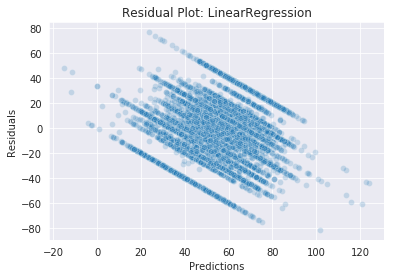

In [49]:
plot_resid(linear_reg, save_path='linear.png', dpi=500)

In [16]:
save_model(linear_reg, 'linear_reg')

# Lasso

In [17]:
param_grid = {'alpha': [10**i for i in range(-3, 4)], 'max_iter': [10_000]}
lasso_best = grid_cv(Lasso(), param_grid)
lasso_best

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'alpha': 0.01, 'max_iter': 10000}

In [18]:
lasso = Lasso(**lasso_best)
lasso.fit(X_train, y_train)
score(lasso, X_train, y_train)

{'mean_absolute_error': 14.91227188145607,
 'mean_squared_error': 369.80098457476475,
 'r2_score': 0.32598207711897287}

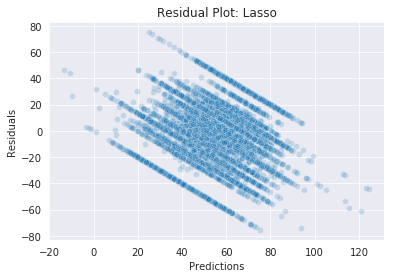

In [50]:
plot_resid(lasso, save_path='lasso.png', dpi=500)

In [88]:
save_model(lasso, 'lasso')

# Ridge

In [20]:
param_grid = {'alpha': [10**i for i in range(-3, 4)]}
ridge_best = grid_cv(Ridge(), param_grid)
ridge_best

{'alpha': 10}

In [21]:
ridge = Ridge(**ridge_best)
ridge.fit(X_train, y_train)
score(ridge, X_train, y_train)

{'mean_absolute_error': 14.910859441172823,
 'mean_squared_error': 369.73593313618096,
 'r2_score': 0.3261006431513622}

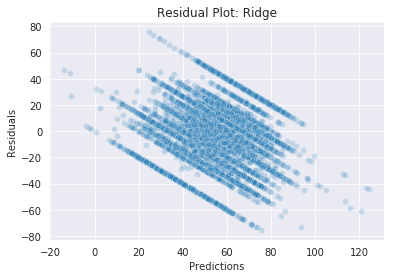

In [51]:
plot_resid(ridge, save_path='ridge.png', dpi=500)

In [23]:
save_model(ridge, 'ridge')

# SVM Regressor

In [24]:
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly']}
svr_best = grid_cv(SVR(), param_grid)
svr_best

{'kernel': 'rbf'}

In [25]:
svr = SVR(**svr_best)
svr.fit(X_train, y_train)
score(svr, X_train, y_train)

{'mean_absolute_error': 12.788972634873259,
 'mean_squared_error': 289.9617126689253,
 'r2_score': 0.4715011602446906}

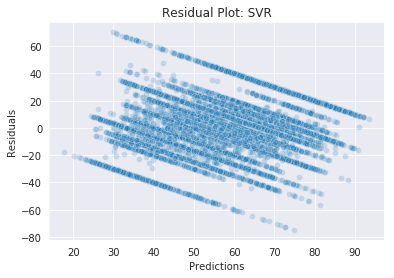

In [52]:
plot_resid(svr, save_path='svr.png', dpi=500)

In [27]:
save_model(svr, 'svr')

# Random Forest

In [28]:
param_grid = {'criterion': ['mse', 'mae'], 'n_jobs': [-1], 'random_state': [0]}
randforest_best = grid_cv(RandomForestRegressor(), param_grid)
randforest_best

{'criterion': 'mse', 'n_jobs': -1, 'random_state': 0}

In [29]:
rand_forest = RandomForestRegressor(**randforest_best)
rand_forest.fit(X_train, y_train)
score(rand_forest, X_train, y_train)

{'mean_absolute_error': 5.361051171393342,
 'mean_squared_error': 55.9830670297301,
 'r2_score': 0.8979624389067596}

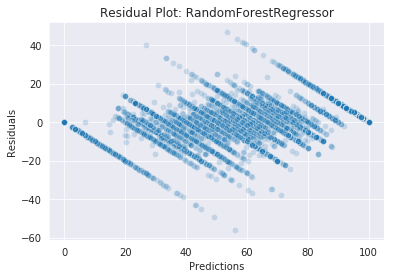

In [53]:
plot_resid(rand_forest, save_path='rand_forest.png', dpi=500)

In [35]:
save_model(rand_forest, 'rand_forest')

# Extra Trees

In [31]:
param_grid = {'criterion': ['mse', 'mae'], 'n_jobs': [-1], 'random_state': [0]}
extra_trees_best = grid_cv(ExtraTreesRegressor(), param_grid)
extra_trees_best

{'criterion': 'mse', 'n_jobs': -1, 'random_state': 0}

In [32]:
extra_trees = ExtraTreesRegressor(**extra_trees_best)
extra_trees.fit(X_train, y_train)
score(extra_trees, X_train, y_train)

{'mean_absolute_error': 0.007706535141803087,
 'mean_squared_error': 0.21407042060556242,
 'r2_score': 0.99960982445622}

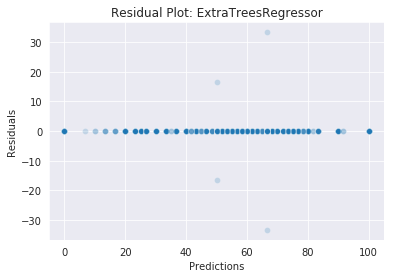

In [54]:
plot_resid(extra_trees, save_path='extra_trees.png', dpi=500)

In [34]:
save_model(extra_trees, 'extra_trees')

# XG Boost

In [37]:
xgboost = XGBRegressor(random_state=0, n_jobs=-1)
xgboost.fit(X_train, y_train)
score(xgboost, X_train, y_train)

{'mean_absolute_error': 12.109849793598382,
 'mean_squared_error': 249.008205635212,
 'r2_score': 0.5461450873756533}

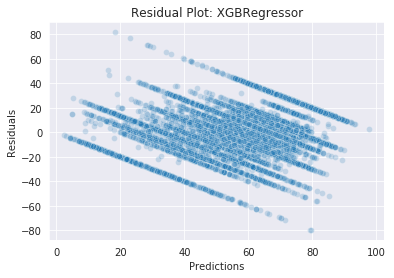

In [55]:
plot_resid(xgboost, save_path='xgboost.png', dpi=500)

In [ ]:
save_model(xgboost, 'xgboost')

# CatBoost

In [41]:
catboost = CatBoostRegressor(random_seed=0, silent=True)
catboost.fit(X_train, y_train)
score(catboost, X_train, y_train)

{'mean_absolute_error': 10.84772371557077,
 'mean_squared_error': 200.77041572756988,
 'r2_score': 0.634065715805854}

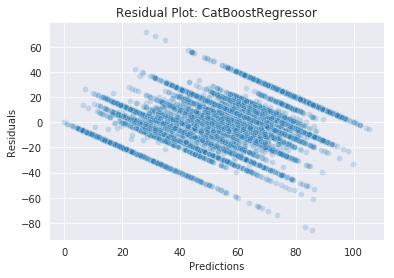

In [56]:
plot_resid(catboost, save_path='catboost.png', dpi=500)

In [40]:
save_model(catboost, 'catboost')

# Gradient Boosting

In [58]:
param_grid = {'loss': ['ls', 'lad', 'huber'], 'random_state': [0]}
gradient_boost_best = grid_cv(GradientBoostingRegressor(), param_grid)
gradient_boost_best

{'loss': 'huber', 'random_state': 0}

In [59]:
gradient_boost = GradientBoostingRegressor(**gradient_boost_best)
gradient_boost.fit(X_train, y_train)
score(gradient_boost, X_train, y_train)

{'mean_absolute_error': 12.042495190869928,
 'mean_squared_error': 248.57934014684102,
 'r2_score': 0.5469267592416693}

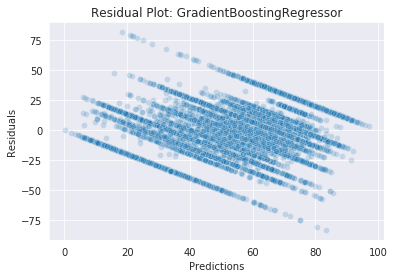

In [61]:
plot_resid(gradient_boost, save_path='gradient_boost.png', dpi=500)

In [ ]:
save_model(gradient_boost, 'gradient_boost')